use output_scene_dataset_4, add albumentation finetuning,APPLY AUGMENTATION TO RAW DEPTH (Fixes the rotation physics) at STEP3,
rotation & flips only




In [ ]:
# ---------------------------
# 0) Install (Colab) - run once
# ---------------------------
!pip install -q torch torchvision --quiet
!pip install -q opencv-python scikit-learn matplotlib tqdm
!pip install -q albumentations

In [ ]:
# ---------------------------
# 1) Imports & Config
# ---------------------------
import os, glob, json, math, time
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
import os
os.listdir("/content/drive/MyDrive")

['Getting started.pdf',
 'Photo Pasport Size.jpeg',
 'Colab Notebooks',
 'AI Y4S1']

In [16]:
# 📌 Step C: Find All Paired Files

import glob
import os
from sklearn.model_selection import train_test_split

data_dir = "/content/drive/MyDrive/AI Y4S1/output_scene_dataset_4"

depth_files = sorted(glob.glob(os.path.join(data_dir, "*dented_depth.npy")))
mask_files = sorted(glob.glob(os.path.join(data_dir, "*dent_mask.png")))

items = list(zip(depth_files, mask_files))
print("Total paired samples:", len(items))

# ---------------------------
# 2) Paths (EDIT if needed)
# ---------------------------
DATA_DIR = data_dir  # <-- set to your folder
OUT_DIR = os.path.join(data_dir, "predictions")
os.makedirs(OUT_DIR, exist_ok=True)


Total paired samples: 1200


In [ ]:
# ---------------------------
# 3) Dataset (BEST VERSION: Safe Augmentations + Correct Physics)
# ---------------------------
import albumentations as A
import cv2
import numpy as np
from torch.utils.data import Dataset

# 1. Define "Safe" Geometric Transformations
# No noise. No distortion. No interpolation blurring.
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5), # <--- This is the key advantage over your old code
    ])

class DepthDentDataset(Dataset):
    def __init__(self, samples: List[Tuple[str,str]], augment: bool=False):
        self.samples = samples
        self.augment = augment
        self.transform = get_train_transforms() if augment else None

    def __len__(self):
        return len(self.samples)

    def _load_depth(self, path):
        return np.load(path).astype(np.float32)

    def _load_mask(self, path):
        p = Path(path)
        if p.suffix.lower() == ".npy":
            m = np.load(path)
            m = (m > 0).astype(np.uint8)
        else:
            m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if m is None: raise RuntimeError(f"Cannot read mask: {path}")
            m = (m > 127).astype(np.uint8)
        return m

    def _fill_holes(self, depth):
        """Basic NaNs filling before augmentation"""
        valid = np.isfinite(depth) & (depth > 0)
        if not np.any(valid):
            return np.zeros_like(depth)
        d_med = np.median(depth[valid])
        depth_filled = depth.copy()
        depth_filled[~valid] = d_med
        return depth_filled

    def _normalize_and_compute_gradients(self, depth):
        """
        Runs AFTER augmentation.
        Ensures gradients match the new rotated orientation.
        """
        # --- 1. Normalize Depth ---
        valid = (depth > 0)
        if not np.any(valid):
            return np.zeros_like(depth), np.zeros_like(depth), np.zeros_like(depth)

        d_min = np.min(depth[valid])
        d_max = np.max(depth[valid])
        range_val = d_max - d_min
        if range_val < 1e-6: range_val = 1.0

        depth_norm = np.zeros_like(depth)
        depth_norm[valid] = 0.1 + 0.9 * ((depth[valid] - d_min) / range_val)

        # --- 2. Compute Gradients ---
        gx = cv2.Sobel(depth_norm, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(depth_norm, cv2.CV_32F, 0, 1, ksize=3)

        # Robust normalization for gradients
        def robust_norm(x):
            v = x[np.isfinite(x)]
            if v.size == 0: return np.zeros_like(x)
            med = np.median(v)
            mad = np.median(np.abs(v - med)) + 1e-6
            out = (x - med) / (3.0 * mad)
            return ((np.clip(out, -3.0, 3.0) + 3.0) / 6.0).astype(np.float32)

        return depth_norm, robust_norm(gx), robust_norm(gy)

    def __getitem__(self, idx):
        depth_path, mask_path = self.samples[idx]
        depth_raw = self._load_depth(depth_path)
        mask = self._load_mask(mask_path)

        # 1. Fill holes first
        depth_clean = self._fill_holes(depth_raw)

        # 2. APPLY AUGMENTATION TO RAW DEPTH
        if self.transform:
            augmented = self.transform(image=depth_clean, mask=mask)
            depth_clean = augmented['image']
            mask = augmented['mask']

        # 3. Compute Gradients ON THE AUGMENTED DATA
        # This is scientifically correct because we calculate slope AFTER rotation
        depth_n, gx, gy = self._normalize_and_compute_gradients(depth_clean)

        # 4. Stack
        image = np.stack([depth_n, gx, gy], axis=-1).astype(np.float32)

        # To Tensor
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        mask = torch.from_numpy(mask).float().unsqueeze(0)

        return image, mask

In [ ]:
# ---------------------------
# 4) Model: Attention-UNet
# ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, padding=1, dropout_rate=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),  # <--- NEW: Randomly zeroes out features
            nn.Conv2d(out_ch, out_ch, kernel, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)   # <--- NEW: Randomly zeroes out features)
        )
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.ReLU(inplace=True),
                                 nn.Conv2d(F_int, 1, kernel_size=1),
                                 nn.Sigmoid())

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Upsample gating signal to match x1 size if needed
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=True)

        psi = self.psi(g1 + x1)
        return x * psi

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        return self.conv(torch.cat([x, skip], dim=1))

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, filters=[32,64,128,256]):
        super().__init__()
        f1, f2, f3, f4 = filters
        self.enc1 = ConvBlock(in_channels, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(f2, f3)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(f3, f4)
        self.pool4 = nn.MaxPool2d(2)
        self.center = ConvBlock(f4, f4*2)

        self.att4 = AttentionGate(F_g=f4*2, F_l=f4, F_int=f4)
        self.dec4 = UpBlock(f4*2, f4)
        self.att3 = AttentionGate(F_g=f4, F_l=f3, F_int=f3)
        self.dec3 = UpBlock(f4, f3)
        self.att2 = AttentionGate(F_g=f3, F_l=f2, F_int=f2)
        self.dec2 = UpBlock(f3, f2)
        self.att1 = AttentionGate(F_g=f2, F_l=f1, F_int=f1)
        self.dec1 = UpBlock(f2, f1)

        self.final = nn.Conv2d(f1, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        c = self.center(self.pool4(e4))

        g4 = c
        x4 = self.att4(g4, e4)
        d4 = self.dec4(c, x4)

        g3 = d4
        x3 = self.att3(g3, e3)
        d3 = self.dec3(d4, x3)

        g2 = d3
        x2 = self.att2(g2, e2)
        d2 = self.dec2(d3, x2)

        g1 = d2
        x1 = self.att1(g1, e1)
        d1 = self.dec1(d2, x1)

        out = self.final(d1)
        return out

In [12]:
# ---------------------------
# 5) Losses & Metrics
# ---------------------------
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1e-6):
        super().__init__()
        self.alpha = alpha # Penalty for False Positives (Noise)
        self.beta = beta   # Penalty for False Negatives (Missing the dent)
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)

        # Flatten
        pred = pred.view(-1)
        target = target.view(-1)

        # True Positives, False Positives, False Negatives
        TP = (pred * target).sum()
        FP = ((1 - target) * pred).sum()
        FN = (target * (1 - pred)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, pred, target):
        # pred: logits
        bce_loss = self.bce(pred, target)
        pt = torch.exp(-bce_loss)
        loss = ((1-pt)**self.gamma * bce_loss).mean()
        return loss

# Update Combined Loss
def combined_loss(pred, target):
    # 0.5 Tversky + 0.5 Focal
    # We prioritize Recall (beta=0.7) to ensure we capture the dent core
    return 0.5 * TverskyLoss(alpha=0.3, beta=0.7)(pred, target) + 0.5 * FocalLoss()(pred, target)

# Metrics
def iou_score_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    union = (pred_bin + target - pred_bin*target).sum(dim=(1,2,3))
    return ((inter + eps) / (union + eps)).mean().item()

def dice_score_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    denom = (pred_bin + target).sum(dim=(1,2,3))
    return ((2*inter + eps) / (denom + eps)).mean().item()

def precision_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    tp = (pred_bin * target).sum(dim=(1,2,3))
    fp = (pred_bin * (1-target)).sum(dim=(1,2,3))
    return ((tp + eps) / (tp + fp + eps)).mean().item()

def recall_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    tp = (pred_bin * target).sum(dim=(1,2,3))
    fn = ((1-pred_bin) * target).sum(dim=(1,2,3))
    return ((tp + eps) / (tp + fn + eps)).mean().item()

In [13]:
# ---------------------------
# 6) Prepare dataset & sampler
# ---------------------------
# Pair depth and mask files
depth_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*dented_depth.npy")))
pairs = []
for dp in depth_paths:
    base = os.path.basename(dp).replace("_dented_depth.npy","")
    mp = os.path.join(DATA_DIR, base + "_dent_mask.png")
    if not os.path.exists(mp):
        mp_alt = os.path.join(DATA_DIR, base + "_dent_mask.npy")
        if os.path.exists(mp_alt):
            mp = mp_alt
        else:
            print("Missing mask for:", dp)
            continue
    pairs.append((dp, mp))

print("Total paired samples:", len(pairs))

# Proper train/val/test split: 70% train, 15% val, 15% test
# First split: separate out test set (15%)
train_val_pairs, test_pairs = train_test_split(pairs, test_size=0.15, random_state=42)
# Second split: split remaining into train (70% of total) and val (15% of total)
# Since we have 85% left, we need 70/85 = 0.8235 to get 70% of original
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.1765, random_state=42)

print(f"Train samples: {len(train_pairs)} ({100*len(train_pairs)/len(pairs):.1f}%)")
print(f"Val samples: {len(val_pairs)} ({100*len(val_pairs)/len(pairs):.1f}%)")
print(f"Test samples: {len(test_pairs)} ({100*len(test_pairs)/len(pairs):.1f}%)")
print("⚠️ Test set is completely separate and will ONLY be used for final evaluation!")

# compute weights for sampler (oversample positive mask images)
def sample_weight(pair):
    _, mask_path = pair
    if mask_path.endswith(".npy"):
        m = np.load(mask_path)
    else:
        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    has_pos = (m > 0).sum() > 0
    return 1.0 if has_pos else 0.2  # give less weight to no-dent images

weights = [sample_weight(p) for p in train_pairs]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_ds = DepthDentDataset(train_pairs, augment=True)
val_ds = DepthDentDataset(val_pairs, augment=False)

train_loader = DataLoader(train_ds, batch_size=4, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)

Total paired samples: 1200
Train samples: 839 (69.9%)
Val samples: 181 (15.1%)
Test samples: 180 (15.0%)
⚠️ Test set is completely separate and will ONLY be used for final evaluation!


In [14]:
# ---------------------------
# 7) Create model / optimizer
# ---------------------------
model = AttentionUNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
)

if scheduler.num_bad_epochs == 0:
    print("↘ LR reduced!")



↘ LR reduced!


In [17]:
# ---------------------------
# 8) Training loop with Early Stopping
# ---------------------------
NUM_EPOCHS = 50  # 50 epochs, but early stopping will prevent overfitting
best_iou = 0.0
save_path = os.path.join(OUT_DIR, "best_attention_unet.pth")

# Early stopping parameters
patience = 7  # Stop if no improvement for 7 epochs
patience_counter = 0
min_delta = 0.001  # Minimum change to qualify as improvement

# Track history for analysis
train_losses = []
val_losses = []
val_ious = []

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0
    for inp, mask in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        inp = inp.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model(inp)
        loss = combined_loss(outputs, mask)
        loss.backward()
        optimizer.step()
        running_loss += float(loss.item())

    # Validation
    model.eval()
    val_loss = 0.0
    iou_acc = 0.0
    dice_acc = 0.0
    prec_acc = 0.0
    rec_acc = 0.0
    n_batches = 0
    with torch.no_grad():
        for inp, mask in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
            inp = inp.to(device)
            mask = mask.to(device)
            outputs = model(inp)
            loss = combined_loss(outputs, mask)
            val_loss += float(loss.item())
            iou_acc += iou_score_batch(outputs, mask)
            dice_acc += dice_score_batch(outputs, mask)
            prec_acc += precision_batch(outputs, mask)
            rec_acc += recall_batch(outputs, mask)
            n_batches += 1

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / (n_batches if n_batches>0 else 1)
    avg_iou = iou_acc / (n_batches if n_batches>0 else 1)
    avg_dice = dice_acc / (n_batches if n_batches>0 else 1)
    avg_prec = prec_acc / (n_batches if n_batches>0 else 1)
    avg_rec = rec_acc / (n_batches if n_batches>0 else 1)

    # Track history
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_ious.append(avg_iou)

    # Calculate gap between train and val loss (overfitting indicator)
    loss_gap = avg_train_loss - avg_val_loss

    print(f"Epoch {epoch}/{NUM_EPOCHS} TrainLoss: {avg_train_loss:.4f} ValLoss: {avg_val_loss:.4f} Val IoU: {avg_iou:.4f} Dice: {avg_dice:.4f} Prec: {avg_prec:.4f} Rec: {avg_rec:.4f} Gap: {loss_gap:.4f}")

    # scheduler step on IoU
    scheduler.step(avg_iou)

    # Early stopping check: improve on IoU
    if avg_iou > best_iou + min_delta:
        best_iou = avg_iou
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"✓ Saved best model (IoU: {best_iou:.4f}): {save_path}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{patience} patience)")

        # Check for overfitting warning
        if loss_gap < -0.05:  # Train loss significantly lower than val loss
            print(f"  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)")

    # Early stopping
    if patience_counter >= patience:
        print(f"\n⏹️  Early stopping triggered! No improvement for {patience} epochs.")
        print(f"Best IoU achieved: {best_iou:.4f} at epoch {epoch - patience}")
        break

print(f"\nTraining complete. Best IoU: {best_iou:.4f}")
print(f"Final train/val loss gap: {train_losses[-1] - val_losses[-1]:.4f}")

Epoch 1 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.10it/s]


Epoch 1/50 TrainLoss: 0.3952 ValLoss: 0.4080 Val IoU: 0.2330 Dice: 0.2869 Prec: 0.2548 Rec: 0.9396 Gap: -0.0129
✓ Saved best model (IoU: 0.2330): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 2 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.23it/s]


Epoch 2/50 TrainLoss: 0.3453 ValLoss: 0.3376 Val IoU: 0.5311 Dice: 0.5900 Prec: 0.5988 Rec: 0.8650 Gap: 0.0077
✓ Saved best model (IoU: 0.5311): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 3 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.07it/s]


Epoch 3/50 TrainLoss: 0.3304 ValLoss: 0.3228 Val IoU: 0.4531 Dice: 0.5141 Prec: 0.5087 Rec: 0.8921 Gap: 0.0076
  No improvement (1/7 patience)


Epoch 4 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.67it/s]


Epoch 4/50 TrainLoss: 0.3269 ValLoss: 0.3068 Val IoU: 0.4759 Dice: 0.5382 Prec: 0.5235 Rec: 0.9001 Gap: 0.0200
  No improvement (2/7 patience)


Epoch 5 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.98it/s]


Epoch 5/50 TrainLoss: 0.3110 ValLoss: 0.3214 Val IoU: 0.4962 Dice: 0.5555 Prec: 0.5596 Rec: 0.8788 Gap: -0.0104
  No improvement (3/7 patience)


Epoch 6 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.68it/s]


Epoch 6/50 TrainLoss: 0.2978 ValLoss: 0.3163 Val IoU: 0.4412 Dice: 0.5034 Prec: 0.4937 Rec: 0.8906 Gap: -0.0185
  No improvement (4/7 patience)


Epoch 7 [val]: 100%|██████████| 46/46 [00:08<00:00,  5.42it/s]


Epoch 7/50 TrainLoss: 0.3013 ValLoss: 0.3000 Val IoU: 0.5090 Dice: 0.5692 Prec: 0.5742 Rec: 0.8860 Gap: 0.0013
  No improvement (5/7 patience)


Epoch 8 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.61it/s]


Epoch 8/50 TrainLoss: 0.2977 ValLoss: 0.2965 Val IoU: 0.4839 Dice: 0.5444 Prec: 0.5235 Rec: 0.9147 Gap: 0.0012
  No improvement (6/7 patience)


Epoch 9 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.03it/s]


Epoch 9/50 TrainLoss: 0.2999 ValLoss: 0.2947 Val IoU: 0.5364 Dice: 0.5948 Prec: 0.6156 Rec: 0.8634 Gap: 0.0051
✓ Saved best model (IoU: 0.5364): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 10 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.09it/s]


Epoch 10/50 TrainLoss: 0.2776 ValLoss: 0.2881 Val IoU: 0.5195 Dice: 0.5787 Prec: 0.5950 Rec: 0.8703 Gap: -0.0105
  No improvement (1/7 patience)


Epoch 11 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.65it/s]


Epoch 11/50 TrainLoss: 0.2715 ValLoss: 0.2955 Val IoU: 0.5518 Dice: 0.6105 Prec: 0.6575 Rec: 0.8255 Gap: -0.0240
✓ Saved best model (IoU: 0.5518): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 12 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.79it/s]


Epoch 12/50 TrainLoss: 0.2818 ValLoss: 0.2845 Val IoU: 0.4983 Dice: 0.5589 Prec: 0.5630 Rec: 0.8860 Gap: -0.0027
  No improvement (1/7 patience)


Epoch 13 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.58it/s]


Epoch 13/50 TrainLoss: 0.2694 ValLoss: 0.2981 Val IoU: 0.5492 Dice: 0.6064 Prec: 0.6531 Rec: 0.8289 Gap: -0.0287
  No improvement (2/7 patience)


Epoch 14 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.78it/s]


Epoch 14/50 TrainLoss: 0.2718 ValLoss: 0.2937 Val IoU: 0.5636 Dice: 0.6235 Prec: 0.6300 Rec: 0.8639 Gap: -0.0219
✓ Saved best model (IoU: 0.5636): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 15 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.68it/s]


Epoch 15/50 TrainLoss: 0.2748 ValLoss: 0.2904 Val IoU: 0.5028 Dice: 0.5630 Prec: 0.5703 Rec: 0.8782 Gap: -0.0156
  No improvement (1/7 patience)


Epoch 16 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.76it/s]


Epoch 16/50 TrainLoss: 0.2730 ValLoss: 0.2886 Val IoU: 0.5698 Dice: 0.6288 Prec: 0.6686 Rec: 0.8422 Gap: -0.0156
✓ Saved best model (IoU: 0.5698): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 17 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.62it/s]


Epoch 17/50 TrainLoss: 0.2694 ValLoss: 0.2853 Val IoU: 0.4837 Dice: 0.5474 Prec: 0.5119 Rec: 0.9239 Gap: -0.0159
  No improvement (1/7 patience)


Epoch 18 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.17it/s]


Epoch 18/50 TrainLoss: 0.2669 ValLoss: 0.2785 Val IoU: 0.5252 Dice: 0.5871 Prec: 0.5818 Rec: 0.8801 Gap: -0.0116
  No improvement (2/7 patience)


Epoch 19 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.88it/s]


Epoch 19/50 TrainLoss: 0.2681 ValLoss: 0.2783 Val IoU: 0.4935 Dice: 0.5587 Prec: 0.5371 Rec: 0.8963 Gap: -0.0101
  No improvement (3/7 patience)


Epoch 20 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.65it/s]


Epoch 20/50 TrainLoss: 0.2583 ValLoss: 0.2719 Val IoU: 0.5256 Dice: 0.5891 Prec: 0.5690 Rec: 0.8927 Gap: -0.0136
  No improvement (4/7 patience)


Epoch 21 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.92it/s]


Epoch 21/50 TrainLoss: 0.2563 ValLoss: 0.2743 Val IoU: 0.4834 Dice: 0.5478 Prec: 0.5218 Rec: 0.8976 Gap: -0.0180
  No improvement (5/7 patience)


Epoch 22 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.67it/s]


Epoch 22/50 TrainLoss: 0.2689 ValLoss: 0.2797 Val IoU: 0.6058 Dice: 0.6671 Prec: 0.6930 Rec: 0.8383 Gap: -0.0108
✓ Saved best model (IoU: 0.6058): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 23 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.00it/s]


Epoch 23/50 TrainLoss: 0.2546 ValLoss: 0.2758 Val IoU: 0.5076 Dice: 0.5708 Prec: 0.5617 Rec: 0.8772 Gap: -0.0212
  No improvement (1/7 patience)


Epoch 24 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.14it/s]


Epoch 24/50 TrainLoss: 0.2552 ValLoss: 0.2742 Val IoU: 0.4941 Dice: 0.5586 Prec: 0.5433 Rec: 0.8809 Gap: -0.0190
  No improvement (2/7 patience)


Epoch 25 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.70it/s]


Epoch 25/50 TrainLoss: 0.2611 ValLoss: 0.2738 Val IoU: 0.5188 Dice: 0.5839 Prec: 0.5704 Rec: 0.8784 Gap: -0.0127
  No improvement (3/7 patience)


Epoch 26 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.93it/s]


Epoch 26/50 TrainLoss: 0.2562 ValLoss: 0.2681 Val IoU: 0.5184 Dice: 0.5832 Prec: 0.5501 Rec: 0.9101 Gap: -0.0119
  No improvement (4/7 patience)


Epoch 27 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.60it/s]


Epoch 27/50 TrainLoss: 0.2403 ValLoss: 0.2765 Val IoU: 0.5698 Dice: 0.6341 Prec: 0.6278 Rec: 0.8650 Gap: -0.0362
  No improvement (5/7 patience)


Epoch 28 [val]: 100%|██████████| 46/46 [00:08<00:00,  5.70it/s]


Epoch 28/50 TrainLoss: 0.2575 ValLoss: 0.2681 Val IoU: 0.4987 Dice: 0.5645 Prec: 0.5363 Rec: 0.9016 Gap: -0.0106
  No improvement (6/7 patience)


Epoch 29 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.27it/s]

Epoch 29/50 TrainLoss: 0.2458 ValLoss: 0.2698 Val IoU: 0.4822 Dice: 0.5476 Prec: 0.5200 Rec: 0.9014 Gap: -0.0240
  No improvement (7/7 patience)

⏹️  Early stopping triggered! No improvement for 7 epochs.
Best IoU achieved: 0.6058 at epoch 22

Training complete. Best IoU: 0.6058
Final train/val loss gap: -0.0240


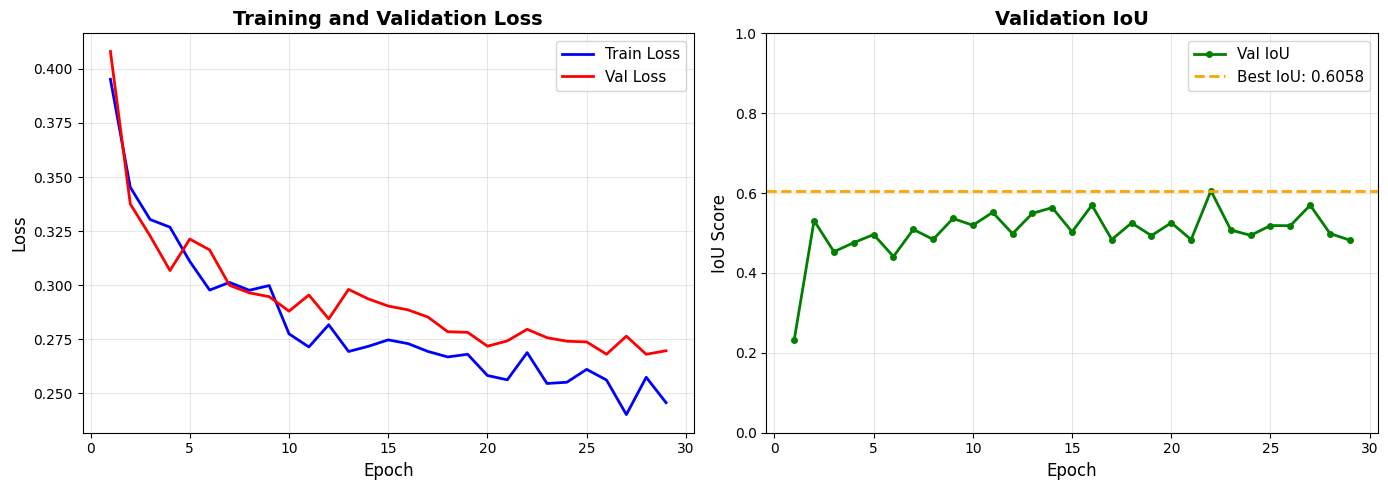


TRAINING ANALYSIS
Best IoU: 0.6058
Final Train Loss: 0.2458
Final Val Loss: 0.2698
Final Loss Gap (Train - Val): -0.0240

✓ Balanced training:
   - Train and validation losses are close
   - Model appears to be learning well


In [18]:
# ---------------------------
# 9) Visualize Training Curves - (Run after training)
# ---------------------------
# Check if training history exists (from training cell)
try:
    # Check if variables exist in global scope
    if 'train_losses' in globals() and len(train_losses) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        epochs = range(1, len(train_losses) + 1)

        # Plot 1: Loss curves
        axes[0].plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
        axes[0].plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)

        # Highlight overfitting region (where gap is large)
        if len(train_losses) > 5:
            gap = np.array(train_losses) - np.array(val_losses)
            overfit_mask = gap < -0.05  # Where train loss is much lower than val loss
            if np.any(overfit_mask):
                axes[0].fill_between(epochs, train_losses, val_losses,
                                     where=overfit_mask, alpha=0.2, color='red',
                                     label='Overfitting region')

        # Plot 2: IoU curve
        axes[1].plot(epochs, val_ious, 'g-', label='Val IoU', linewidth=2, marker='o', markersize=4)
        axes[1].axhline(y=best_iou, color='orange', linestyle='--',
                        label=f'Best IoU: {best_iou:.4f}', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('IoU Score', fontsize=12)
        axes[1].set_title('Validation IoU', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])

        plt.tight_layout()
        plt.show()

        # Print analysis
        final_gap = train_losses[-1] - val_losses[-1]
        print("\n" + "="*60)
        print("TRAINING ANALYSIS")
        print("="*60)
        print(f"Best IoU: {best_iou:.4f}")
        print(f"Final Train Loss: {train_losses[-1]:.4f}")
        print(f"Final Val Loss: {val_losses[-1]:.4f}")
        print(f"Final Loss Gap (Train - Val): {final_gap:.4f}")

        if final_gap < -0.05:
            print("\n⚠️  OVERFITTING DETECTED:")
            print("   - Train loss is significantly lower than validation loss")
            print("   - Model is memorizing training data rather than generalizing")
            print("   - Consider: more regularization, dropout, or data augmentation")
        elif final_gap > 0.05:
            print("\n✓ Good generalization:")
            print("   - Validation loss is lower than training loss")
            print("   - Model is generalizing well")
        else:
            print("\n✓ Balanced training:")
            print("   - Train and validation losses are close")
            print("   - Model appears to be learning well")
    else:
        print("⚠️ Training history is empty. Run the training cell first.")
except NameError:
    print("⚠️ Training history not available. Please run the training cell (Cell 10) first.")


In [ ]:
# ---------------------------
# 10) Fine-Tuning (Cool Down Phase)
# ---------------------------
print("\nStarting Fine-Tuning (Low LR, No Augmentation)...")

# 1. Load the best weights from the main training
model.load_state_dict(torch.load(save_path))

# 2. Use a smaller Learning Rate
ft_optimizer = optim.Adam(model.parameters(), lr=1e-5) # 100x smaller

# 3. Create a non-augmented train loader
ft_dataset = DepthDentDataset(train_pairs, augment=False) # <--- False
ft_loader = DataLoader(ft_dataset, batch_size=4, shuffle=True, num_workers=2)

# Initialize tracking
best_ft_iou = best_iou  # Start with the best IoU from main training
ft_save_path = save_path.replace(".pth", "_finetuned.pth")

# 4. Train for just 5-10 epochs
FT_EPOCHS = 10
for epoch in range(1, FT_EPOCHS+1):
    model.train()
    running_loss = 0.0
    for inp, mask in tqdm(ft_loader, desc=f"Fine-Tune {epoch}"):
        inp = inp.to(device)
        mask = mask.to(device)
        ft_optimizer.zero_grad()
        outputs = model(inp)
        loss = combined_loss(outputs, mask)
        loss.backward()
        ft_optimizer.step()
        running_loss += loss.item()

    # Check Validation
    model.eval()
    val_iou = 0.0
    with torch.no_grad():
        for inp, mask in val_loader:
            inp = inp.to(device)
            mask = mask.to(device)
            outputs = model(inp)
            val_iou += iou_score_batch(outputs, mask, thr=0.5) # Use default 0.5 for now

    val_iou /= len(val_loader)
    print(f"FT Epoch {epoch} -> Loss: {running_loss/len(ft_loader):.4f} | Val IoU: {val_iou:.4f}")

    # Save if it improved OR if it's the first fine-tune epoch (to ensure file exists)
    if val_iou >= best_ft_iou:
        best_ft_iou = val_iou
        torch.save(model.state_dict(), ft_save_path)
        print(f"✓ Improved Fine-Tuned model saved! IoU: {best_ft_iou:.4f}")


Starting Fine-Tuning (Low LR, No Augmentation)...


Fine-Tune 1: 100%|██████████| 210/210 [01:37<00:00,  2.16it/s]


FT Epoch 1 -> Loss: 0.3040 | Val IoU: 0.5361


Fine-Tune 2: 100%|██████████| 210/210 [01:36<00:00,  2.18it/s]


FT Epoch 2 -> Loss: 0.3019 | Val IoU: 0.5498


Fine-Tune 3: 100%|██████████| 210/210 [01:36<00:00,  2.18it/s]


FT Epoch 3 -> Loss: 0.2978 | Val IoU: 0.5621


Fine-Tune 4: 100%|██████████| 210/210 [01:36<00:00,  2.18it/s]


FT Epoch 4 -> Loss: 0.2943 | Val IoU: 0.4735


Fine-Tune 5:  24%|██▍       | 50/210 [00:23<01:13,  2.18it/s]

In [ ]:
# ---------------------------
# 11) Optimize Threshold
# ---------------------------
#### model.load_state_dict(torch.load(save_path)) # Load your best model


# LOGIC: Check if fine-tuned model exists, otherwise use base model
ft_save_path = save_path.replace(".pth", "_finetuned.pth")

if os.path.exists(ft_save_path):
    print(f"Loading Fine-Tuned Model: {os.path.basename(ft_save_path)}")
    model.load_state_dict(torch.load(ft_save_path))
else:
    print(f"Loading Base Model: {os.path.basename(save_path)}")
    model.load_state_dict(torch.load(save_path))

model.eval()


thresholds = np.arange(0.3, 0.8, 0.05)
best_thr = 0.5
best_val_iou = 0.0

print("Optimizing threshold on Validation Set...")
for thr in thresholds:
    iou_acc = 0.0
    n_batches = 0
    with torch.no_grad():
        for inp, mask in val_loader:
            inp = inp.to(device)
            mask = mask.to(device)
            outputs = model(inp)
            # Use the custom threshold here
            iou_acc += iou_score_batch(outputs, mask, thr=thr)
            n_batches += 1

    avg_iou = iou_acc / n_batches
    print(f"Thr: {thr:.2f} -> IoU: {avg_iou:.4f}")

    if avg_iou > best_val_iou:
        best_val_iou = avg_iou
        best_thr = thr

print(f"\n🏆 Best Threshold found: {best_thr:.2f} with IoU: {best_val_iou:.4f}")
print("Use this threshold for your final testing!")

In [ ]:
# ---------------------------
# 12) Final Test: TTA, Metrics & Saving
# ---------------------------
import os
import cv2
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

print("\n================ TEST EVALUATION (W/ TTA) & SAVING ================\n")

# 1. Setup Output Directory
pred_out_dir = os.path.join(OUT_DIR, "batch_preds")
os.makedirs(pred_out_dir, exist_ok=True)
print(f"Saving images to: {pred_out_dir}")

# 2. Load Data & Model
ft_save_path = save_path.replace(".pth", "_finetuned.pth")

if os.path.exists(ft_save_path):
    print(f"Testing with Fine-Tuned Model: {os.path.basename(ft_save_path)}")
    model.load_state_dict(torch.load(ft_save_path, map_location=device))
else:
    print(f"Testing with Base Model: {os.path.basename(save_path)}")
    model.load_state_dict(torch.load(save_path, map_location=device))

model.eval()

test_ds = DepthDentDataset(test_pairs, augment=False)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2)

# 3. Metrics Trackers
test_iou = 0.0
test_dice = 0.0
test_prec = 0.0
test_rec = 0.0
n_batches = 0
total_file_idx = 0

# 4. Post-processing Kernel (for cleaning noise)
kernel = np.ones((3,3), np.uint8)

with torch.no_grad():
    for inp, mask in tqdm(test_loader, desc="Testing & Saving"):
        inp = inp.to(device)
        mask = mask.to(device)

        # --- A. Test-Time Augmentation (TTA) ---
        # 1. Standard Prediction
        pred_standard = torch.sigmoid(model(inp))

        # 2. Horizontal Flip Prediction
        inp_h = torch.flip(inp, [3])      # Flip Input horizontally
        out_h = torch.sigmoid(model(inp_h))
        pred_h = torch.flip(out_h, [3])   # Flip Output back

        # 3. Vertical Flip Prediction
        inp_v = torch.flip(inp, [2])      # Flip Input vertically
        out_v = torch.sigmoid(model(inp_v))
        pred_v = torch.flip(out_v, [2])   # Flip Output back

        # Average them (Boosts Score!)
        outputs = (pred_standard + pred_h + pred_v) / 3.0

        # --- B. Calculate Metrics ---
        test_iou  += iou_score_batch(outputs, mask, thr=best_thr)
        test_dice += dice_score_batch(outputs, mask, thr=best_thr)
        test_prec += precision_batch(outputs, mask, thr=best_thr)
        test_rec  += recall_batch(outputs, mask, thr=best_thr)
        n_batches += 1

        # --- C. Save Images ---
        preds_prob = outputs.cpu().numpy() # (B, 1, H, W)
        inputs_np = inp.cpu().numpy()      # (B, 3, H, W)
        masks_np = mask.cpu().numpy()      # (B, 1, H, W)

        batch_size = inputs_np.shape[0]

        for i in range(batch_size):
            if total_file_idx >= len(test_pairs): break
            original_path = test_pairs[total_file_idx][0]
            base = os.path.basename(original_path).replace("_dented_depth.npy", "")

            # 1. Depth Image
            depth_img = (inputs_np[i, 0] * 255).astype(np.uint8)

            # 2. GT Mask
            gt_img = (masks_np[i, 0] * 255).astype(np.uint8)

            # 3. Pred Mask (Raw)
            # FIX: Use best_thr, not 0.5
            pred_raw = (preds_prob[i, 0] > best_thr).astype(np.uint8)

            # 4. Cleaned Pred Mask (Morphology)
            # Remove noise specks (Opening) then fill holes (Closing)
            pred_clean = cv2.morphologyEx(pred_raw, cv2.MORPH_OPEN, kernel, iterations=1)
            pred_clean = cv2.morphologyEx(pred_clean, cv2.MORPH_CLOSE, kernel, iterations=1)

            # Convert to image
            pred_img = pred_clean * 255

            # Save
            cv2.imwrite(os.path.join(pred_out_dir, base + "_pred.png"), pred_img)
            cv2.imwrite(os.path.join(pred_out_dir, base + "_gt_depth.png"), depth_img)
            cv2.imwrite(os.path.join(pred_out_dir, base + "_gt_mask.png"), gt_img)

            # Side-by-Side
            if gt_img.shape != depth_img.shape:
                gt_img = cv2.resize(gt_img, (depth_img.shape[1], depth_img.shape[0]), interpolation=cv2.INTER_NEAREST)

            side_by_side = np.hstack([depth_img, gt_img, pred_img])
            cv2.imwrite(os.path.join(pred_out_dir, base + "_compare.png"), side_by_side)

            total_file_idx += 1

# 5. Print Final Averaged Metrics
avg_test_iou  = test_iou / n_batches
avg_test_dice = test_dice / n_batches
avg_test_prec = test_prec / n_batches
avg_test_rec  = test_rec / n_batches

print("\n========== FINAL TEST RESULTS (With TTA) ==========")
print(f"Threshold used: {best_thr:.2f}")
print(f"Test IoU      : {avg_test_iou:.4f}")
print(f"Test Dice     : {avg_test_dice:.4f}")
print(f"Test Precision: {avg_test_prec:.4f}")
print(f"Test Recall   : {avg_test_rec:.4f}")
print(f"✅ Images saved to: {pred_out_dir}")
print("===================================================\n")

In [ ]:
# ---------------------------
# 13) Visualization of Results
# ---------------------------
import matplotlib.pyplot as plt

# Get the list of prediction images we just saved
pred_files = sorted(glob.glob(os.path.join(pred_out_dir, "*_pred.png")))

# Pick random 3 or take first 3
num_to_show = min(20, len(pred_files))
vis_samples = pred_files[:num_to_show]

if len(vis_samples) == 0:
    print("No predictions found to visualize.")
else:
    for i, pred_path in enumerate(vis_samples):
        # Derive paths based on naming convention in Step 9
        base = os.path.basename(pred_path).replace("_pred.png", "")

        # Load Depth (Visual)
        depth_vis_path = os.path.join(pred_out_dir, base + "_gt_depth.png")
        if os.path.exists(depth_vis_path):
            depth_img = cv2.imread(depth_vis_path, cv2.IMREAD_GRAYSCALE)
        else:
            depth_img = np.zeros((256,256), dtype=np.uint8) # Fallback

        # Load GT Mask
        gt_mask_path = os.path.join(pred_out_dir, base + "_gt_mask.png")
        if os.path.exists(gt_mask_path):
            gt_mask_img = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            gt_mask_img = np.zeros_like(depth_img)

        # Load Prediction
        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        # Plot
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Sample: {base}", fontsize=14)

        plt.subplot(1, 3, 1)
        plt.title("Input Depth (Norm)")
        plt.imshow(depth_img, cmap="viridis")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(gt_mask_img, cmap="gray")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_img, cmap="gray")
        plt.axis('off')

        plt.tight_layout()
        plt.show()